### Time Series Analysis - Superstore
##### Time Series analysis can be used to extract meaningful data using different methods.

In [43]:
# Importing dependencies

import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

##### Items of several categories are available in superstore data, we'll start with furniture sales available for time series analysis and sales forcasting.

In [45]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [46]:
# Loading the data of interest 'Furniture Sales' into another dataframe named 'furniture'

df = pd.read_csv(r"Superstore.csv")
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])

In [47]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

##### 1st and last Date of the sale of furniture shows we've data for 4 years.

#### Data Preprocessing
##### Removing the data we don't need, check for missing or null values and aggregate sales by date and different operations.

In [50]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

# Dropping every column except Order Date and Sales, will later club the sales for each date.
furniture.drop(cols, axis=1, inplace=True)

# Sorting on the basis on order date, default setting of ascending order
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [51]:
# Getting the aggregrate sales by date.
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [52]:
# Ensuring 'Order Date' is in datetime format
furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])

# Setting Order Date as the index 
furniture.set_index('Order Date', inplace = True)

In [53]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

##### Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [55]:
# If we have data for sales of furniture in a month, then this query will transform it into average sales of that month and will match it with first date of the month

y = furniture['Sales'].resample('MS').mean()     

In [56]:
# All the data for one particular month is now converted into average sales for that particular month.

y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

#### Visualizing Furniture Sales Time Series Data

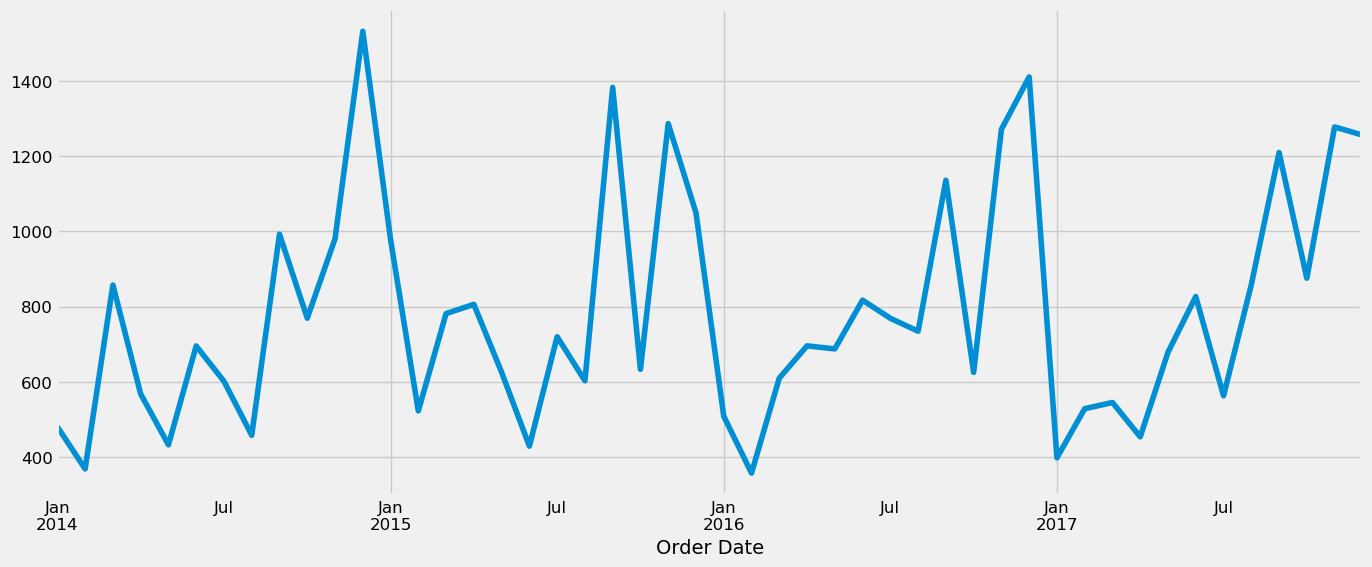

In [58]:
y.plot(figsize=(15, 6))
plt.show()

##### For every year, we can see seasonality in our data for sales for furniture, such as sales are always low at the starting of the month and high near the end which is because of the festive season around christmas and new year. In general, there is always an upward trend with some low sales month in between.

##### Visualizing our data using time series decomposition method into Trend, Seasonality and Nosie will help us better understand the sales. The below breakdown shows that sales of Furniture is unstable, along with some seasonality.

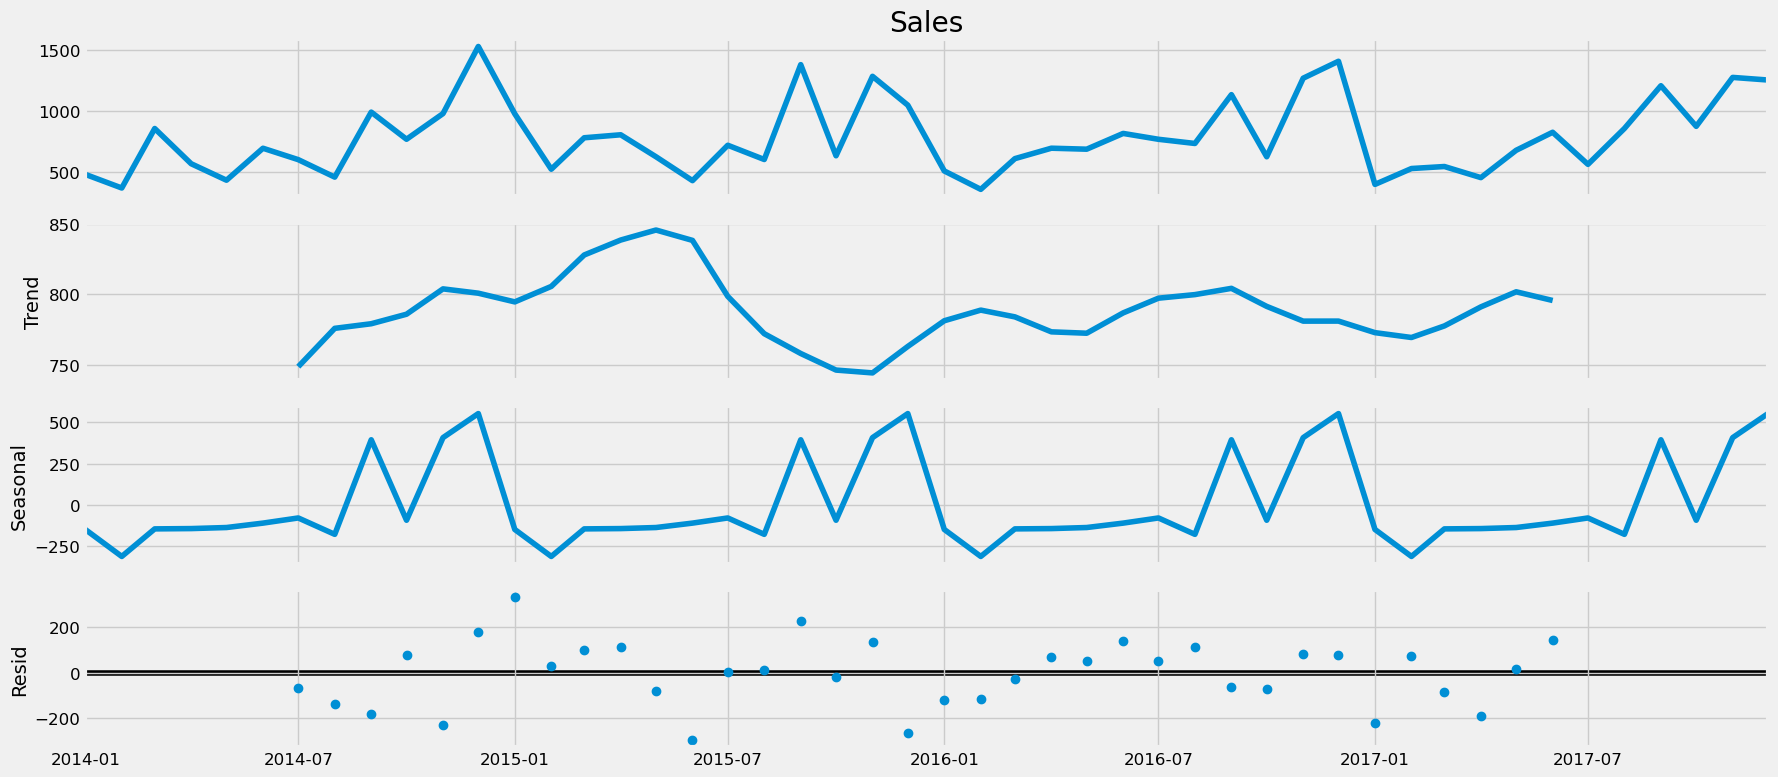

In [61]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Time series forecasting with ARIMA

##### The most commonly used time series analysis model, ARIMA Model will be useful here to extract out some crucial insights. In this model, we uses three parameterms ARIMA(p, d, q) which accounts for seasonality, trend and noise in our data. 

In [63]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


##### This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [309]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1446.2880169233042
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919128
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997936844
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1268.674682697129
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803018147
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758099
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2678.6685431884252
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091625
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673283
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5788795267372
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2494.0095963541935
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576524723
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1447.9090630237827
AR

##### The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

In [317]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1751      0.176      0.994      0.320      -0.170       0.520
ma.L1         -1.0000      0.267     -3.746      0.000      -1.523      -0.477
ar.S.L6       -0.8800      0.075    -11.723      0.000      -1.027      -0.733
sigma2      5.013e+04   5.32e-06   9.42e+09      0.000    5.01e+04    5.01e+04


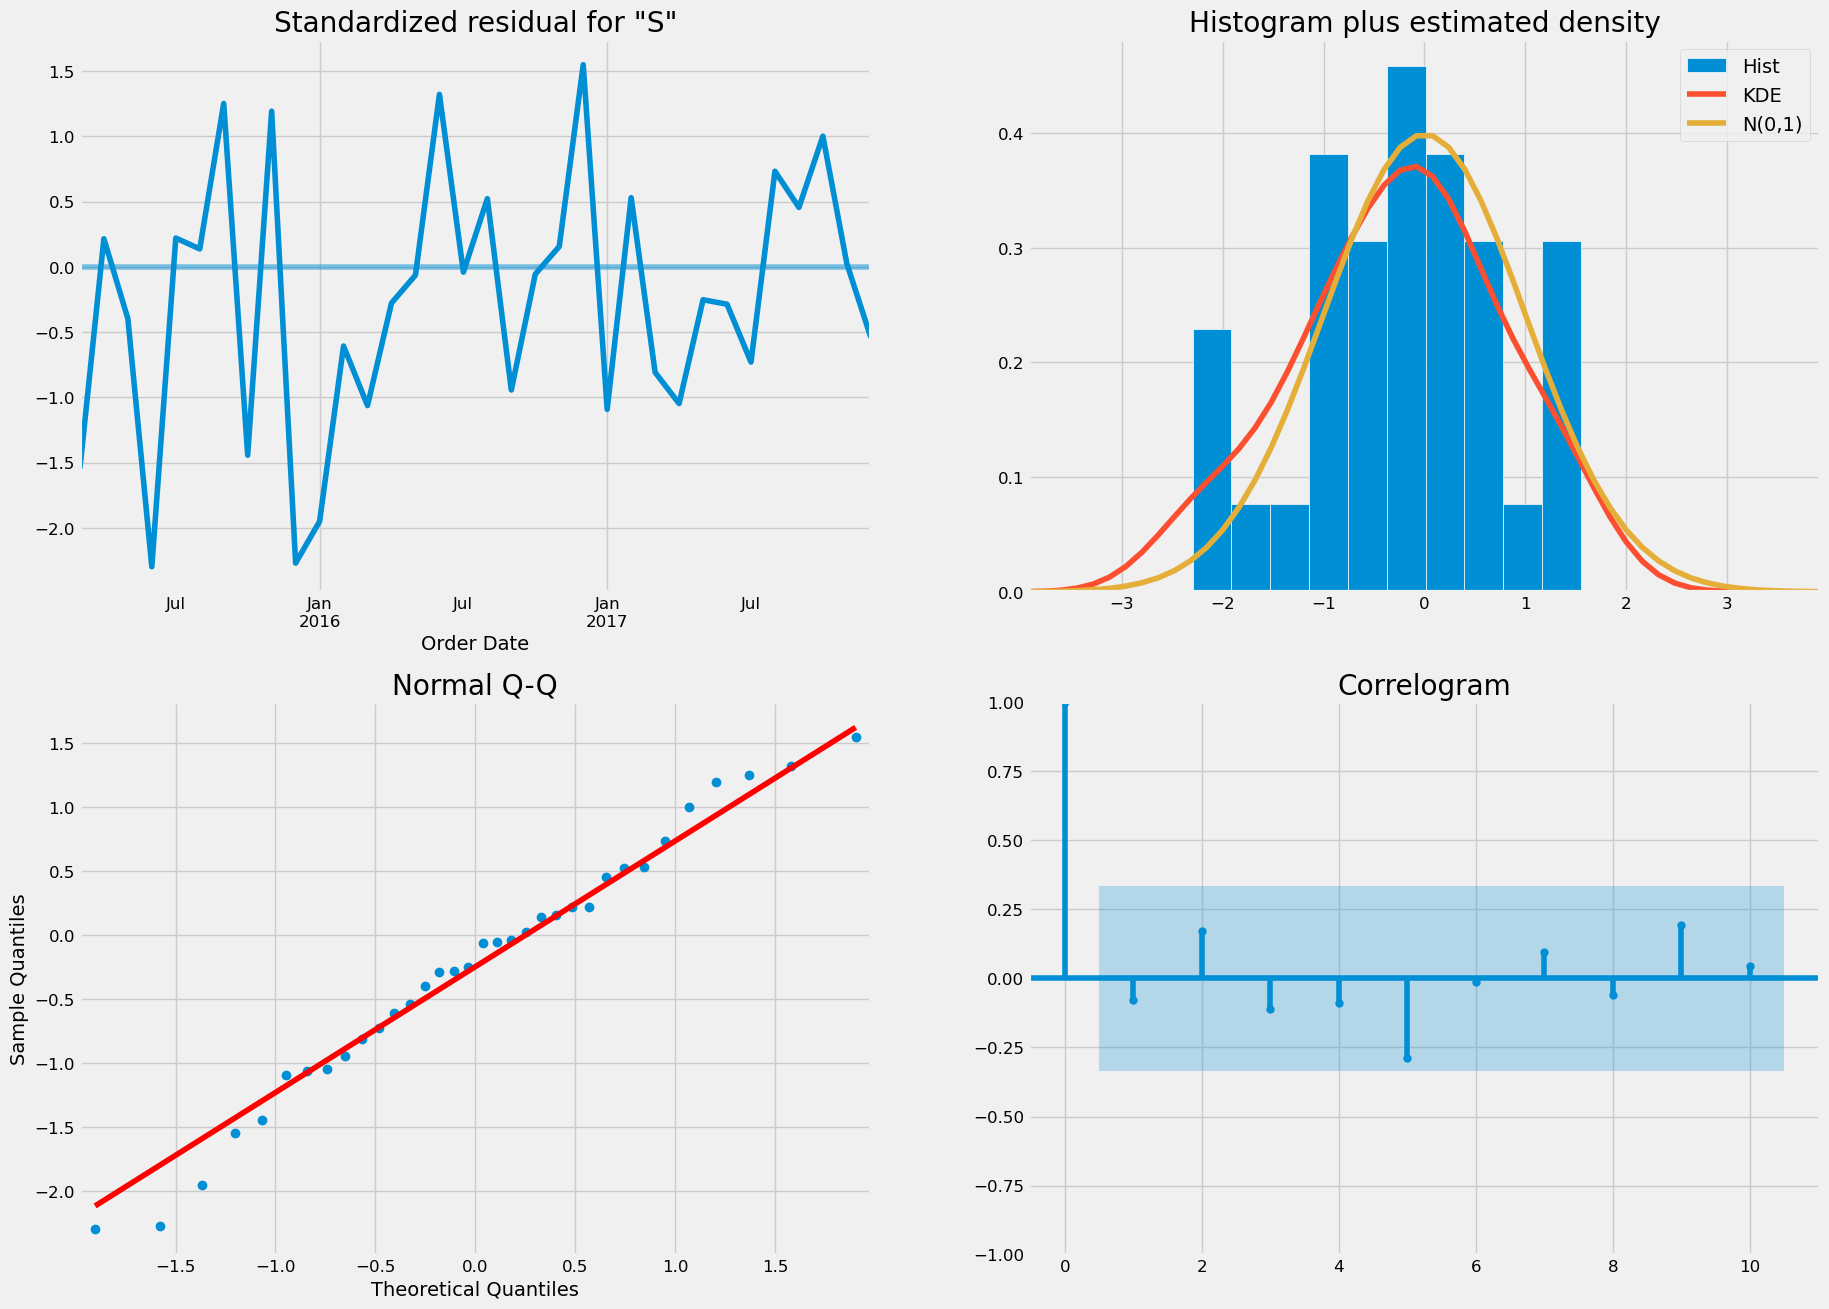

In [319]:
results.plot_diagnostics(figsize=(20, 15))
plt.show()

### Validating forecasts
##### To understand the accuracy of our model, we ompare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

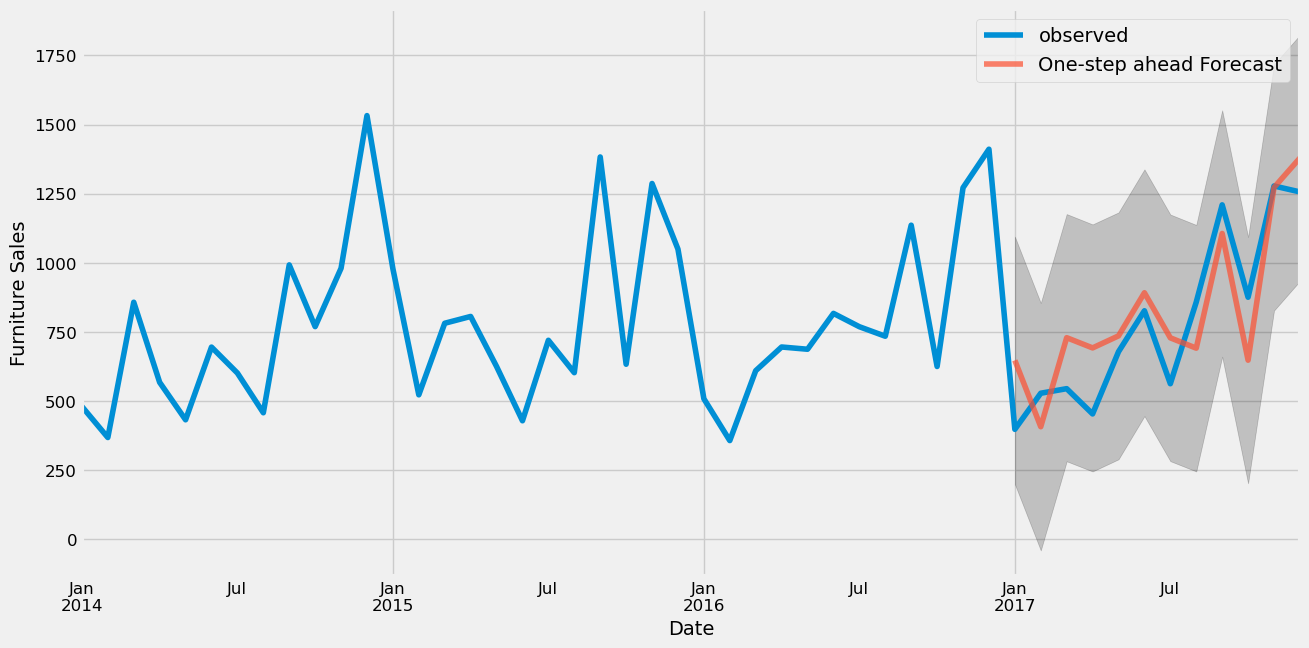

In [322]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

##### The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [325]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 25706.58


In [327]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 160.33


##### RMSE tell us that our model here, was able to forecast the average daily furniture sales in the test set within 160.33 of the real sales. Our furniture daily sales range from around 400 to over 1200. 

### Producing and visualizing forecasts

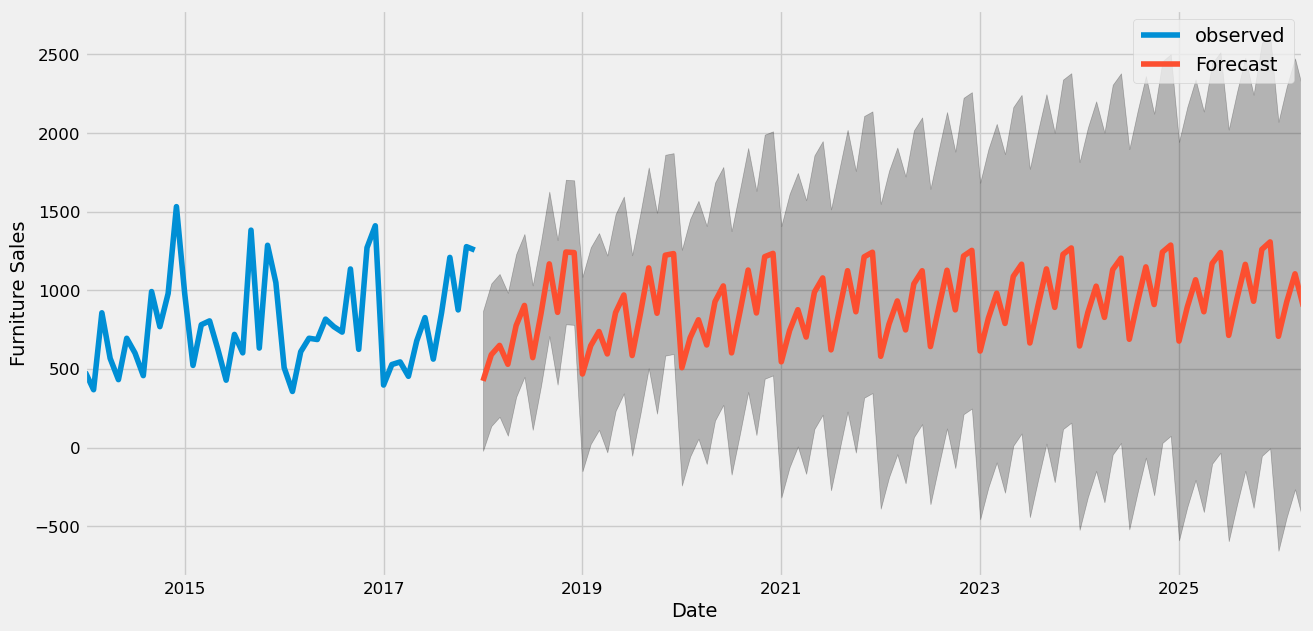

In [331]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

##### We clearly see, the model captured furniture sales seasonality. Also, as we forecast further out into the future, it was natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

### Time Series of Furniture vs. Office Supplies
##### According to our data, there were way more number of sales from Office Supplies Category than from Furniture over the years.

In [334]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

furniture['Order Date'] = pd.to_datetime(furniture['Order Date'])
office['Order Date'] = pd.to_datetime(office['Order Date'])

#### Data Exploration

##### We are going to compare two categories’ sales in the same time period. This means we need to combine two data frames into one and plot these two categories’ time series into one single plot.

In [337]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 
        'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
# furniture.drop(cols, axis=1, inplace=True)
# office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)

In [338]:
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


##### Now we've got the sales data for both the categories, Furniture and Office Supplies as an average sale.

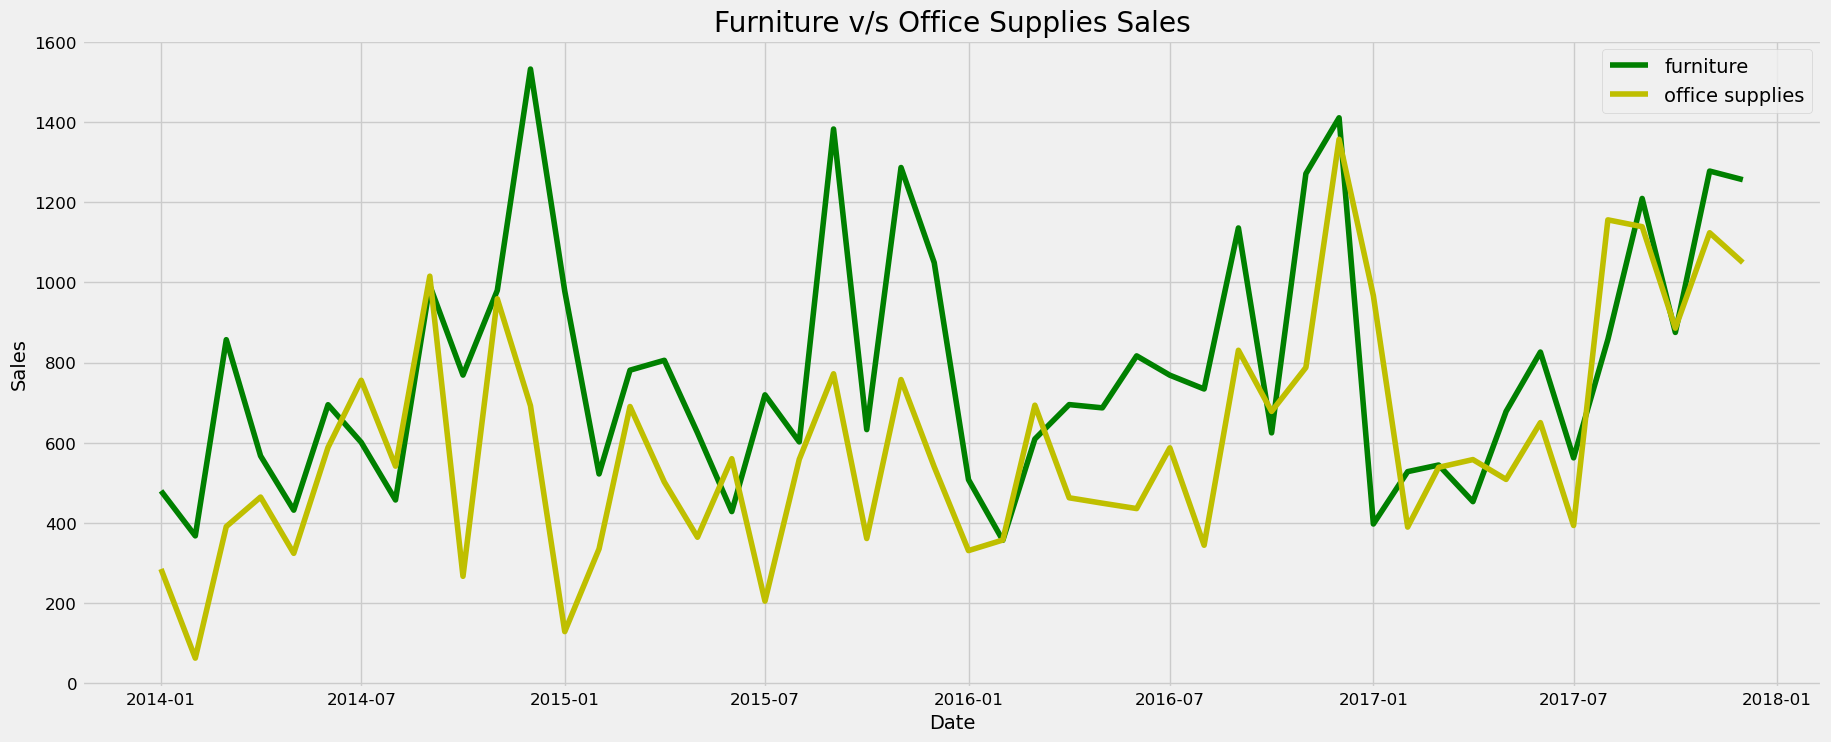

In [340]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'g-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'y-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Furniture v/s Office Supplies Sales')
plt.legend();

##### Trend for Furniture and Office Supplies sales from our dataset. Some seasonality and some noise can be easily observed in both these trends. Sales in the begining of the year is low for both categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. 

##### Occasionally, office supplies passed furniture on average daily sales. Through the below code, we can find out when was the first time office supplies' sales surpassed that of furniture sales.

In [343]:
# Find the first date where office sales exceeded furniture sales
first_date = store.loc[np.min(np.where(store['office_sales'] > store['furniture_sales'])[0]), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


### Time Series Modeling with Prophet
##### Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

In [345]:
!pip install --upgrade prophet

In [346]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

13:00:50 - cmdstanpy - INFO - Chain [1] start processing
13:00:51 - cmdstanpy - INFO - Chain [1] done processing
13:00:51 - cmdstanpy - INFO - Chain [1] start processing
13:00:52 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1800x600 with 0 Axes>

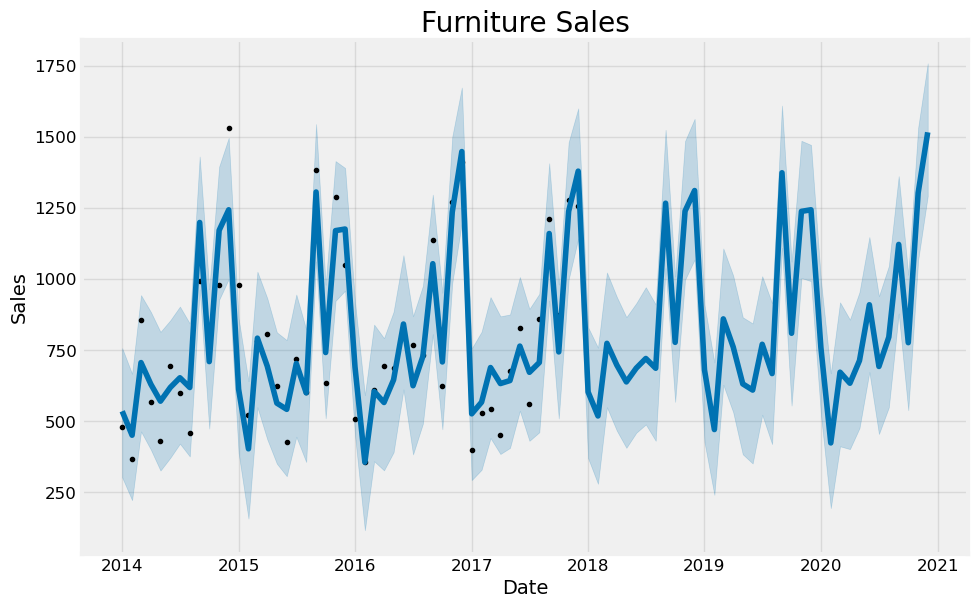

In [347]:
# Furniture sales forecasting

plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1800x600 with 0 Axes>

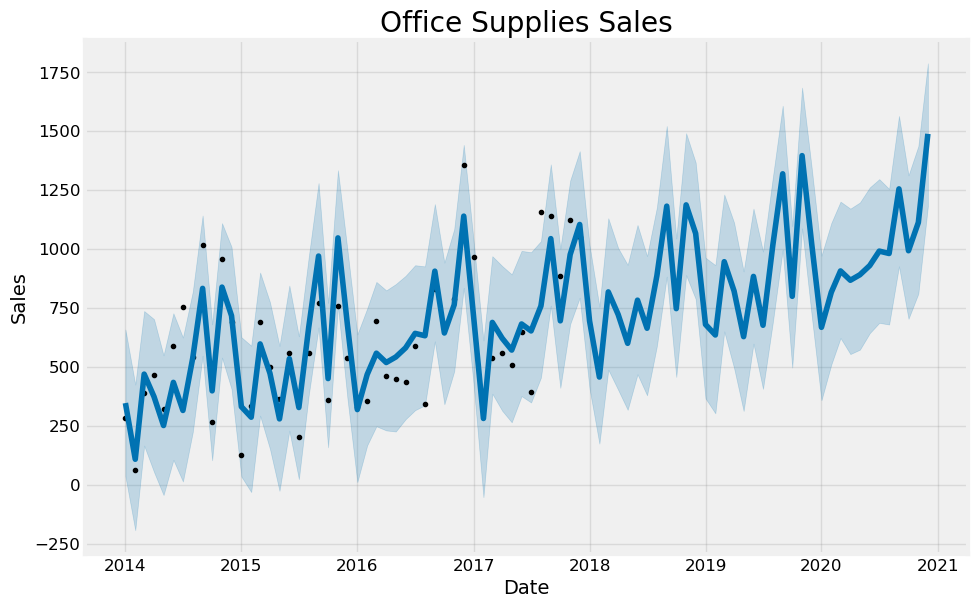

In [348]:
# Office Supplies Sales Forecasting

plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

### Compare Forecasts
##### We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [356]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,302.883017,757.231438,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,222.875087,666.991013,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,464.404379,943.386185,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,400.185561,884.107265,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,326.923883,814.246467,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


### Trend and Forecast Visualization

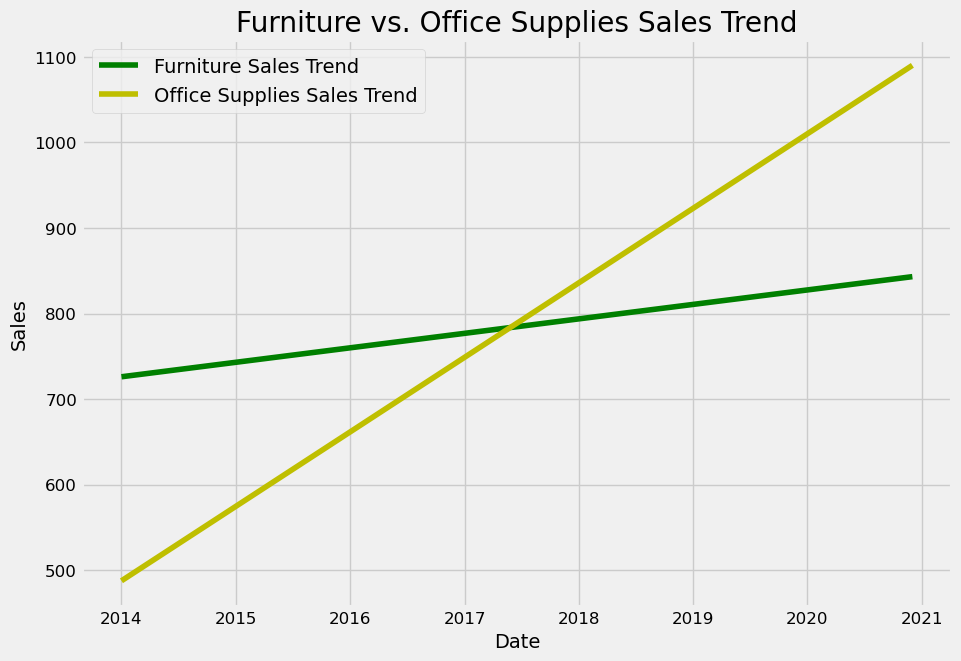

In [358]:
plt.figure(figsize=(10, 7))

# Add labels for each plot
plt.plot(forecast['Date'], forecast['furniture_trend'], 'g-', label='Furniture Sales Trend')
plt.plot(forecast['Date'], forecast['office_trend'], 'y-', label='Office Supplies Sales Trend')

# Now, legend() will display these labels
plt.legend()

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend')
plt.show()

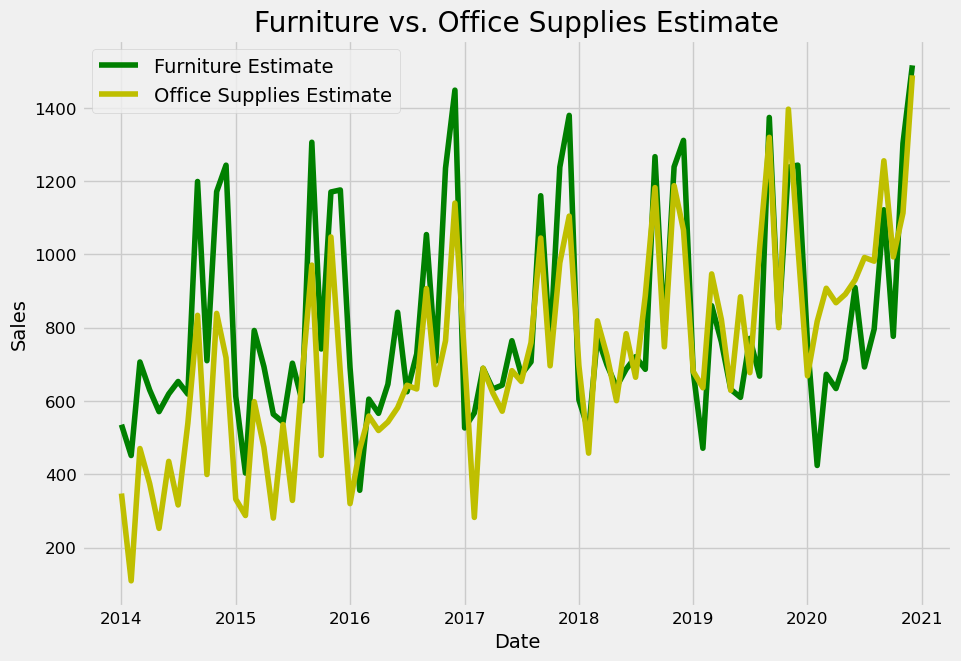

In [359]:
plt.figure(figsize=(10, 7))

# Add labels for each plot line
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'g-', label='Furniture Estimate')
plt.plot(forecast['Date'], forecast['office_yhat'], 'y-', label='Office Supplies Estimate')

# Legend will now include these labels
plt.legend()

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate')
plt.show()

### Trend and Pattern
##### We can use the Prophet Models to inspect different trends of these two categories in the data.

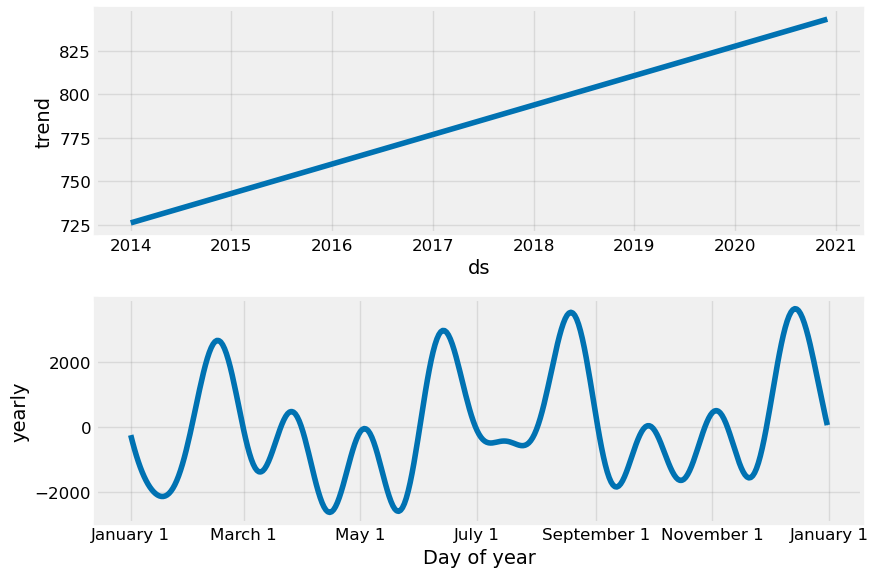

In [361]:
furniture_model.plot_components(furniture_forecast);

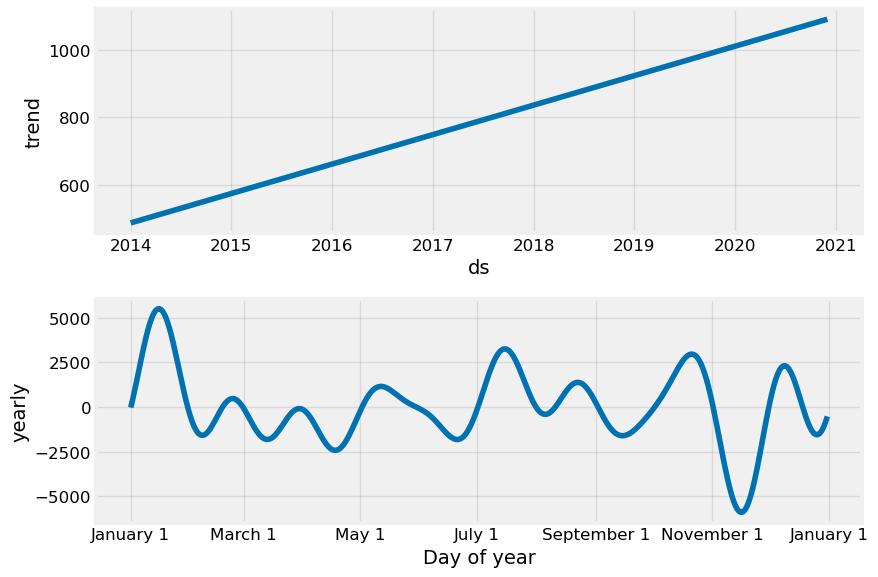

In [362]:
office_model.plot_components(office_forecast);

##### It's encouraging to see that sales for both furniture and office supplies have shown a steady linear increase over time, with office supplies exhibiting slightly stronger growth. 

##### For furniture, April stands out as the lowest-performing month, while February is the weakest month for office supplies. On the other hand, December marks the peak for furniture sales, whereas October is the best month for office supplies.

##### There are numerous time-series analyses we could explore going forward. These include forecasting with uncertainty intervals, detecting change points and anomalies, and using external data sources to enhance the time-series forecasts. We’re just scratching the surface here.